<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/fitzhugh_kapral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install enum34

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# [Microscopic model for FitzHugh-Nagumo dynamics](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.55.5657)

original Fitzhugh-Nagumo equation:

$$
u_\tau = -u^3 + u - v \\
v_\tau = \epsilon(u - \alpha v - \beta)
$$

Spatially distributed form:

$$
u_\tau = -u^3 + u - v + D_u \nabla^2 u \\
v_\tau = \epsilon(u - \alpha v - \beta) D_v \nabla^2 v
$$

This paper:  depart from the standard interpretation of the
FitzHugh-Nagumo (FHN) model in terms of nerve impulse
physiology and devise a chemical scheme whose mass-action
law is the FHN equation. The goal is to construct a microscopic collision dynamics corresponding to the
mechanism and implement it in the context of a lattice-gas
automaton.

## Fitzhugh-Nagumo reaction kinetics



## Lattice-Gas Model

Once a chemical mechanism is known it is possible to
devise a microscopic reactive collision dynamics that accounts for the steps in the mechanism. In the paper, the mechanism is implemented as a reactive lattice-gas automaton. 

### Notation

- $\mathcal{L}$: The coordinate space of the model. A regular Bravais lattice is used
- $\mathcal{l}$: An elementary site on the lattice
- $\mathcal{B}$: The space of all possible site conffigurations
- each site $\mathcal{l}$ can be occupied by a number of particles
  - the occupation numbers of different species are independent
  - it follows that $\mathcal{B}$ is a direct product of particle states


### Brownian Motion

The model uses an additional "excited" substate $\mathbb{E}$. Motion then works through a 3-step algorithm:

1. Transfer at most 1 particle per side to the excited state, with a probability depending on the site occupation number
2. Translate the excited particles in a random direction chosen from a set of directions $V={v_1,\dots, v_k}$
3. Accomodate the excited particles at their new locations

-> Two restrictions immediately follow from our definition.
- Only $N$ particles of a species can reside at a site ==> $p(N)=1$
- We can't create excited particles out of nothing ==> $p(0)=0$

We can specify this algorithm using the example of translating particles of a species $A$:

The lattice state is defined by the substates of the species $A$, $\mathbb{A}$ and the auxiliary excited species E, $\mathbb{E}$.

$$\mathbb{L}=(\mathbb{A},\mathbb{E})$$

If we define the maximum occupation number as $N$, then we can express the algorithm as:

$$
\mathcal{D} = \mathcal{C}_\alpha \circ \mathcal{T}_v \circ \mathcal{C}_\tau
$$

**$\mathcal{C}_\tau$** 
****

$\mathcal{C}_\tau$ is a lattice operator corresponding to 1. (transfer a particle to the "excited" state). The lattice operator defines the application of the following site operator independently at each site $\mathcal{l}=(n,e)$, where $n$ is the number of molecules of species $A$ at site $\mathcal{l}$ and $e$ is the number of excited particles at site $\mathcal{l}$:

$$
\tau(n,e) = \textbf{(} (n-\theta(n-N\xi)),\theta(n-N\xi)\textbf{)}
$$

Here, $\theta$ is the heaviside function and $\xi$ is a continuous uniform random variable on (0,1).

**$\mathcal{T}_v$**
****
Translate $\mathbb{E}$ into a random direction $v$. Corresponds to 2.

**$\mathcal{C}_\alpha$**
****
$\mathcal{C}_\alpha$ is a lattice operator that corresponds to 3. ("Accomodate the excited particles at their new locations"). It defines the application of the following site operator to each site $\mathcal{l}$:

$$
\alpha(n,e) = \textbf{(} (n+e), (0) \textbf{)}
$$

In [2]:
from typing import Tuple, List
from enum import Enum
import torch as t
from torch.distributions import uniform
import random
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [3]:
class Direction2D(Enum):
  North_West = 0
  North = 1
  North_East = 2
  West = 3
  Center = 4
  East = 5
  South_West = 6
  South = 7
  South_East = 8


for direction in enumerate(Direction2D):
  print(direction)

(0, <Direction2D.North_West: 0>)
(1, <Direction2D.North: 1>)
(2, <Direction2D.North_East: 2>)
(3, <Direction2D.West: 3>)
(4, <Direction2D.Center: 4>)
(5, <Direction2D.East: 5>)
(6, <Direction2D.South_West: 6>)
(7, <Direction2D.South: 7>)
(8, <Direction2D.South_East: 8>)


In [4]:
def translate(grid: t.Tensor, v:Direction2D) -> t.Tensor:
  translate_north = translate_west = [*t.arange(1, grid.shape[1]), 0]
  translate_south = translate_east = [-1, *t.arange(grid.shape[1]-1)]

  if v == Direction2D.North_West:
    return grid[:, :, translate_west][:, translate_north, :]
  elif v == Direction2D.West:
    return grid[:, :, translate_west]
  elif v == Direction2D.South_West:
    return grid[:, :, translate_west][:, translate_south, :]
  elif v == Direction2D.North:
    return grid[:, translate_north, :]
  elif v == Direction2D.Center:
    return grid
  elif v == Direction2D.South:
    return grid[:, translate_south, :]
  elif v == Direction2D.North_East:
    return grid[:, translate_north, :][:, :, translate_east]
  elif v == Direction2D.East:
    return grid[:, :,translate_east]
  elif v == Direction2D.South_East:
    return grid[:, translate_south, :][:, :, translate_east]
  else:
    raise Exception("Invalid translation direction")


In [ ]:
state = t.zeros((2,3,3))
state[0,0,0] = 1
state[0,1,0] = 1
state[0,1,1] = 1
print(state)

translate(state, Direction2D.North_West)

tensor([[[1., 0., 0.],
         [1., 1., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])


tensor([[[1., 0., 1.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [ ]:
s1 = t.arange(18).reshape((2,3,3))

expectation_north_west = t.tensor([
    [
      [s1[0,1,1], s1[0,1,2], s1[0,1,0]],
      [s1[0,2,1], s1[0,2,2], s1[0,2,0]],
      [s1[0,0,1], s1[0,0,2], s1[0,0,0]],
    ],
    [
      [s1[1,1,1], s1[1,1,2], s1[1,1,0]],
      [s1[1,2,1], s1[1,2,2], s1[1,2,0]],
      [s1[1,0,1], s1[1,0,2], s1[1,0,0]],
    ]
])

expectation_north = t.tensor([
    [
      [s1[0,1,0], s1[0,1,1], s1[0,1,2]],
      [s1[0,2,0], s1[0,2,1], s1[0,2,2]],
      [s1[0,0,0], s1[0,0,1], s1[0,0,2]],
    ],
    [
      [s1[1,1,0], s1[1,1,1], s1[1,1,2]],
      [s1[1,2,0], s1[1,2,1], s1[1,2,2]],
      [s1[1,0,0], s1[1,0,1], s1[1,0,2]],
    ]
])

expectation_north_east = t.tensor([
    [
      [s1[0,1,2], s1[0,1,0], s1[0,1,1]],
      [s1[0,2,2], s1[0,2,0], s1[0,2,1]],
      [s1[0,0,2], s1[0,0,0], s1[0,0,1]],
    ],
    [
      [s1[1,1,2], s1[1,1,0], s1[1,1,1]],
      [s1[1,2,2], s1[1,2,0], s1[1,2,1]],
      [s1[1,0,2], s1[1,0,0], s1[1,0,1]],
    ]
])

expectation_west = t.tensor([
    [
      [s1[0,0,1], s1[0,0,2], s1[0,0,0]],
      [s1[0,1,1], s1[0,1,2], s1[0,1,0]],
      [s1[0,2,1], s1[0,2,2], s1[0,2,0]],
    ],
    [
      [s1[1,0,1], s1[1,0,2], s1[1,0,0]],
      [s1[1,1,1], s1[1,1,2], s1[1,1,0]],
      [s1[1,2,1], s1[1,2,2], s1[1,2,0]],
    ]
])

expectation_east = t.tensor([
    [
      [s1[0,0,2], s1[0,0,0], s1[0,0,1]],
      [s1[0,1,2], s1[0,1,0], s1[0,1,1]],
      [s1[0,2,2], s1[0,2,0], s1[0,2,1]],
    ],
    [
      [s1[1,0,2], s1[1,0,0], s1[1,0,1]],
      [s1[1,1,2], s1[1,1,0], s1[1,1,1]],
      [s1[1,2,2], s1[1,2,0], s1[1,2,1]],
    ]
])

expectation_south_west = t.tensor([
    [
      [s1[0,2,1], s1[0,2,2], s1[0,2,0]],
      [s1[0,0,1], s1[0,0,2], s1[0,0,0]],
      [s1[0,1,1], s1[0,1,2], s1[0,1,0]],
    ],
    [
      [s1[1,2,1], s1[1,2,2], s1[1,2,0]],
      [s1[1,0,1], s1[1,0,2], s1[1,0,0]],
      [s1[1,1,1], s1[1,1,2], s1[1,1,0]],
    ]
])

expectation_south = t.tensor([
    [
      [s1[0,2,0], s1[0,2,1], s1[0,2,2]],
      [s1[0,0,0], s1[0,0,1], s1[0,0,2]],
      [s1[0,1,0], s1[0,1,1], s1[0,1,2]],
    ],
    [
      [s1[1,2,0], s1[1,2,1], s1[1,2,2]],
      [s1[1,0,0], s1[1,0,1], s1[1,0,2]],
      [s1[1,1,0], s1[1,1,1], s1[1,1,2]],
    ]
])

expectation_south_east = t.tensor([
    [
      [s1[0,2,2], s1[0,2,0], s1[0,2,1]],
      [s1[0,0,2], s1[0,0,0], s1[0,0,1]],
      [s1[0,1,2], s1[0,1,0], s1[0,1,1]],
    ],
    [
      [s1[1,2,2], s1[1,2,0], s1[1,2,1]],
      [s1[1,0,2], s1[1,0,0], s1[1,0,1]],
      [s1[1,1,2], s1[1,1,0], s1[1,1,1]],
    ]
])

assert t.all(translate(s1, Direction2D.North_West) == expectation_north_west)
assert t.all(translate(s1, Direction2D.North) == expectation_north)
assert t.all(translate(s1, Direction2D.North_East) == expectation_north_east)
assert t.all(translate(s1, Direction2D.West) == expectation_west)
assert t.all(translate(s1, Direction2D.Center) == s1)
assert t.all(translate(s1, Direction2D.East) == expectation_east)
assert t.all(translate(s1, Direction2D.South_West) == expectation_south_west)
assert t.all(translate(s1, Direction2D.South) == expectation_south)
assert t.all(translate(s1, Direction2D.South_East) == expectation_south_east)

In [5]:
def excite_particles(state:t.Tensor, N:int) -> Tuple[t.Tensor, t.Tensor]:
  """
  Returns the adjusted Lattice + auxiliary grid of "excited" particles E.
  """
  grid_dim =  state.shape[-1]
  Xi = uniform.Uniform(0,1).sample_n(2*(grid_dim**2)).reshape(2,grid_dim,grid_dim)
  E = t.heaviside(state - N * Xi, values=t.zeros(state.shape))
  return state - E, E

In [6]:
def accomodate_particles(state:t.Tensor, E:t.Tensor) -> t.Tensor:
  """
  Merges E into the current grid state.
  """
  return state + E

In [7]:
def diffuse(state:t.Tensor, N:int) -> t.Tensor:
  state, E = excite_particles(state, N)
  direction = random.choice(list(Direction2D))
  E = translate(E, direction)
  state = accomodate_particles(state, E)
  return state

In [ ]:
grid = t.zeros((2,3,3))
grid[:,1,1] = 250
for i in range(20):
  grid = diffuse(grid, 256)
  print(grid[0])

tensor([[  0.,   0.,   0.],
        [  0., 249.,   1.],
        [  0.,   0.,   0.]])
tensor([[  0.,   0.,   0.],
        [  0., 248.,   1.],
        [  0.,   0.,   1.]])
tensor([[  0.,   1.,   0.],
        [  0., 247.,   1.],
        [  0.,   0.,   1.]])
tensor([[  0.,   1.,   0.],
        [  0., 246.,   1.],
        [  1.,   0.,   1.]])
tensor([[  1.,   1.,   0.],
        [  0., 245.,   1.],
        [  1.,   0.,   1.]])
tensor([[  2.,   1.,   0.],
        [  0., 244.,   1.],
        [  1.,   0.,   1.]])
tensor([[  2.,   1.,   1.],
        [  0., 243.,   1.],
        [  1.,   0.,   1.]])
tensor([[  2.,   1.,   1.],
        [  0., 242.,   1.],
        [  2.,   0.,   1.]])
tensor([[  2.,   2.,   1.],
        [  0., 241.,   1.],
        [  2.,   0.,   1.]])
tensor([[  3.,   2.,   1.],
        [  0., 240.,   1.],
        [  2.,   0.,   1.]])
tensor([[  3.,   3.,   1.],
        [  0., 239.,   1.],
        [  2.,   0.,   1.]])
tensor([[  3.,   2.,   1.],
        [  0., 238.,   2.],
        [

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [8]:
grid = t.zeros((2,50,50))
grid[:,15:30] = 200
print(t.sum(grid))

tensor(300000.)


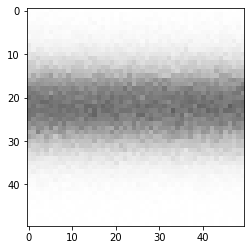

100%|██████████| 10000/10000 [00:52<00:00, 192.21it/s]


tensor(300000.)

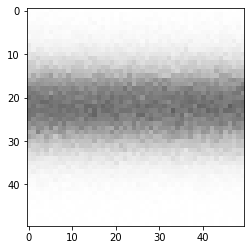

In [10]:
N = 256 
for i in tqdm(range(10_000)):
  if i % 100 == 0:
    display.clear_output(wait=True)
    plt.imshow(grid[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=256)
    display.display(plt.gcf())
  grid = diffuse(grid, N)
t.sum(grid)

## Reactive Dynamics

The lattice state $\mathbb{L}$ is given by $\mathbb{L} = (\mathbb{A}, \mathbb{B})$. Each lattice site $\mathcal{l}$ is then defined by the occupation numbers
$\mathcal{l} = (n,m)$, where $n$ is the number of particles of species A and $m$ the number of particles of species B currently residing at site $\mathcal{l}$.

The reaction rule is carried out by randomly choosing one of 6 possible reaction channels ($r=6$). Each channel is assigned an equal weight in the choice. The reactive dynamics arise from birth-death processes based on the 6 possible reaction channels. The probability of a reaction also depends on the chosen channel and is given by:

$$
p_1(n,m) = \gamma \overline{k_1} n (n-1)(N-n) \\
p_2(n,m) = \gamma \overline{k^*_1} n (N-n) (N-1-n) \\
p_3(n,m) = \gamma \overline{k_2} (N-n)m \\
p_4(n,m) = \gamma \overline{k^*_2} n(N-m) \\
p_5(n,m) = \gamma \overline{k^*_3} (N-n)(N-m) \\ 
p_6(n,m) = \gamma \overline{k_3}n m
$$

- $\gamma$ is a scale factor that controls the timescale of the reaction 
- $\overline{k_1} = k_1 / [(N-1)(N-2)]$
- $\overline{k_1^*} = k_1^* / [(N-1)(N-2)]$
- $\overline{k_2} = k_2 / N$
- $\overline{k_2^*} = k_2^* / N$
- $\overline{k_3} = k_3 / N$
- $\overline{k_3^*} = k_3^* / N$

where $k_i$ and $k_i^*$ are the reaction rate coefficients.

****

We can use the probabilities to define the site operators for the reactive dynamics. Let $\xi$ be a random continuous uniform variable on (0,1), then:

$$
\sigma_1(n,m) = (n + \theta(p_1 - \xi), m) \\
\sigma_2(n,m) = (n - \theta(p_2 - \xi), m) \\
\sigma_3(n,m) = (n + \theta(p_3 - \xi), m) \\
\sigma_4(n,m) = (n - \theta(p_4 - \xi), m) \\
\sigma_5(n,m) = (n, m + \theta(p_5 - \xi)) \\
\sigma_6(n,m) = (n, m - \theta(p_6 - \xi))
$$

We can combine these operators into a site operator for the local reaction rule. Let $\nu$ be a discrete random variable on the domain $\{1,\dots,r\}$, then:

$$
\rho(n,m) = \sum_{j=1}^6 \delta_{\nu j} \sigma_j(n,m)
$$

where $\delta_{\nu j}$ is the kronecker delta and is equal to 1 if $j = \nu$, 0 otherwise.

In [ ]:
def p1(state:t.Tensor, N:int, gamma:float, k1:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k1_bar = k1 / ((N-1) * (N-2))
  return gamma * k1_bar * n * (n-1) * (N - n)

def p2(state:t.Tensor, N:int, gamma:float, k1_star:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k1_star_bar = k1_star /  ((N-1) * (N-2))
  return gamma * k1_star_bar * n * (N-n) * (N-1-n)

def p3(state:t.Tensor, N:int, gamma:float, k2:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k2_bar = k2 / N
  return gamma * k2_bar * (N - n) * m

def p4(state:t.Tensor, N:int, gamma:float, k2_star:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k2_star_bar = k2_star / N
  return gamma * k2_star_bar * n * (N - m)

def p5(state:t.Tensor, N:int, gamma:float, k3:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k3_bar = k3 / N
  return gamma * k3_bar * (N - n) * (N - m)

def p6(state:t.Tensor, N:int, gamma:float, k3_star:float) -> t.Tensor:
  n = state[0]
  m = state[1]
  k3_star_bar = k3_star / N
  return gamma * k3_star_bar * n * m

probability_funcs = [p1,p2,p3,p4,p5,p6]

In [ ]:
def sigma(state:t.Tensor, channel:int, N:int, gamma:float, rate_coefficients: List[float]):
  grid_dim = state.shape[-1]
  rate_coefficient = rate_coefficients[channel]
  reaction_prob = probability_funcs[channel](state, gamma, N, rate_coefficient)
  threshold = uniform.Uniform(0,1).sample_n(grid_dim**2).reshape(grid_dim, grid_dim)
  if channel == 0 or channel == 2:
    state[0] = state[0] + t.heaviside(reaction_prob - threshold, values=t.zeros(grid_dim, grid_dim))
  elif channel == 1 or channel == 3:
    state[0] = state[0] - t.heaviside(reaction_prob - threshold, values=t.zeros(grid_dim, grid_dim))
  elif channel == 4:
    state[1] = state[1] + t.heaviside(reaction_prob - threshold, values=t.zeros(grid_dim, grid_dim))
  elif channel == 5:
    state[1] = state[1] - t.heaviside(reaction_prob - threshold, values=t.zeros(grid_dim, grid_dim))
  return state

In [ ]:
def rho(state:t.Tensor, N:int, gamma:float, rate_coefficients: List[float]):
  channel = t.randint_like()
  channel = random.randint(0,5)
  return sigma(state, channel, N, gamma, rate_coefficients)

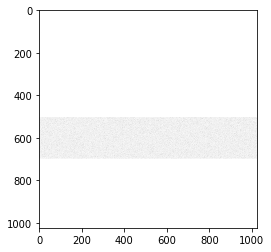

 12%|█▏        | 1210/10000 [01:22<09:57, 14.71it/s]


KeyboardInterrupt: ignored

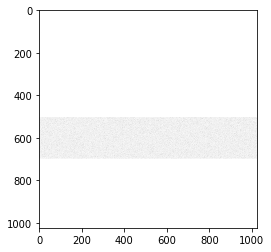

In [ ]:
grid = t.zeros((2,1024,1024))
grid[:,500:700] = 200
N = 256 
gamma = 0.6
rate_coefficients = [0.98,0.98,0.1,0.1,0.2,0.2]
for i in tqdm(range(10_000)):
  if i % 500 == 0:
    display.clear_output(wait=True)
    plt.imshow(grid[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=256)
    display.display(plt.gcf())
  grid = rho(grid, N, gamma, rate_coefficients)
  grid = diffuse(grid, N)
  #display.clear_output(wait=True)
  #time.sleep(0.02)